## Bibliotecas Utilizadas

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import spacy
import regex as re
from collections import Counter
from operator import itemgetter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud


In [3]:
# Function to remove emoji.
def emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [4]:
def tokenize(texto):
    doc = nlp.tokenizer(texto)
    return [token.lower_ for token in doc if not token.is_punct]

In [5]:
def unnest_tokens(df, # Data Frame (em linhas)
                  coluna_tokenize, # nome da coluna com os textos (tweets)
                  coluna_token_nome='palavra', # nome da coluna com os tokens
                  tokenizer_function=tokenize): # what tokenizer to use
    
    return (df[coluna_tokenize]
              .apply(tokenizer_function)
              .apply(pd.Series)
              .stack()
              .reset_index(level=0)
              .set_index('level_0')
              .rename(columns={0: coluna_token_nome})
              .join(df.drop(coluna_tokenize, 1), how='left')
              .reset_index(drop=True))

In [170]:
def clean_stopwords(df, coluna_token="palavra"):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    df = df[~ df[coluna_token].isin(stop_words_portugues | stop_words_ingles | stop_words_espanhol | symbols)]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if re.match(r'http*', w) != None)]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if emoji_pattern.match(w) != None)]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if (w.startswith('@') | w.startswith('#') | w.startswith('\r')))]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if w == 'rt')]
    return df

# Carregando os dados 

In [6]:
# Dataframe com todos os politicos e seus tweets
lista_dir = os.listdir("./politicos/")
nome_politicos = []
df_politicos = pd.DataFrame()
for nome in lista_dir:
    df_politico = pd.read_csv(
        f"./politicos/{nome}",
        delimiter=",",
        encoding='utf-8',
        usecols=[1,2,8]
    )
    df_politico['nome'] = nome[:-4]
    nome_politicos.append(nome[:-4])
    df_politicos = df_politicos.append(df_politico)
cols = ['nome'] + [col for col in df_politicos if col != 'nome']
df_politicos = df_politicos[cols]
df_politicos.reset_index(inplace=True)

In [8]:
df_politicos.head(10)

index    nome            created_at  \
0      0  Amoedo  2021-04-19T16:18:20Z   
1      1  Amoedo  2021-04-19T16:05:53Z   
2      2  Amoedo  2021-04-19T15:32:40Z   
3      3  Amoedo  2021-04-19T12:53:14Z   
4      4  Amoedo  2021-04-19T12:25:58Z   
5      5  Amoedo  2021-04-19T12:19:42Z   
6      6  Amoedo  2021-04-18T19:21:07Z   
7      7  Amoedo  2021-04-18T19:21:06Z   
8      8  Amoedo  2021-04-18T15:42:35Z   
9      9  Amoedo  2021-04-18T15:42:25Z   

                                                text                   id  
0  RT @MBLivre: Presidente americano Joe Biden an...  1384179569712713735  
1  Temos que fazer a nossa parte. Não podemos dei...  1384176435552608259  
2  O governo federal e o Congresso ignoraram no O...  1384168077697314825  
3  RT @o_antagonista: .@joaoamoedonovo sugeriu no...  1384127951311040517  
4                     Informações de @OGloboPolitica  1384121090243383296  
5  A CPI da Pandemia no Senado deve investigar o ...  1384119514418216969  
6  Leia a coluna completa em https://t.co/rvNDUpnqgA  1383863178853969921  
7  "Membros do Executivo e do Legislativo não ace...  1383863176891015168  
8                       Informações de @RevistaEpoca  1383808183223734272  
9  O governo federal gastará R$500 mil em uma cam...  1383808141897342986

In [8]:
df_politicos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31633 entries, 0 to 31632
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       31633 non-null  int64 
 1   nome        31633 non-null  object
 2   created_at  31633 non-null  object
 3   text        31633 non-null  object
 4   id          31633 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.2+ MB


# WordClouds e outras análises

In [40]:
# stopwords e simbolos a retirar
stop_words_portugues = set(stopwords.words('portuguese'))
stop_words_ingles = set(stopwords.words('english'))
stop_words_espanhol = set(stopwords.words('spanish'))
symbols = set(['-', 'r$', 'R$', '|'])

In [9]:
nlp = spacy.load("pt_core_news_sm")

In [159]:
# criando dataframe apenas com as palavras e os politicos
df_palavras = unnest_tokens(df_politicos.drop(['index','created_at','id'], axis=1), 'text')

In [160]:
df_palavras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905721 entries, 0 to 905720
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   palavra  905721 non-null  object
 1   nome     905721 non-null  object
dtypes: object(2)
memory usage: 13.8+ MB


In [171]:
df_palavras = clean_stopwords(df_palavras)

In [172]:
df_palavras.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481396 entries, 2 to 905720
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   palavra  481396 non-null  object
 1   nome     481396 non-null  object
dtypes: object(2)
memory usage: 11.0+ MB


In [173]:
df_palavras.head()

palavra    nome
2  presidente  Amoedo
3   americano  Amoedo
4         joe  Amoedo
5       biden  Amoedo
6     anuncia  Amoedo

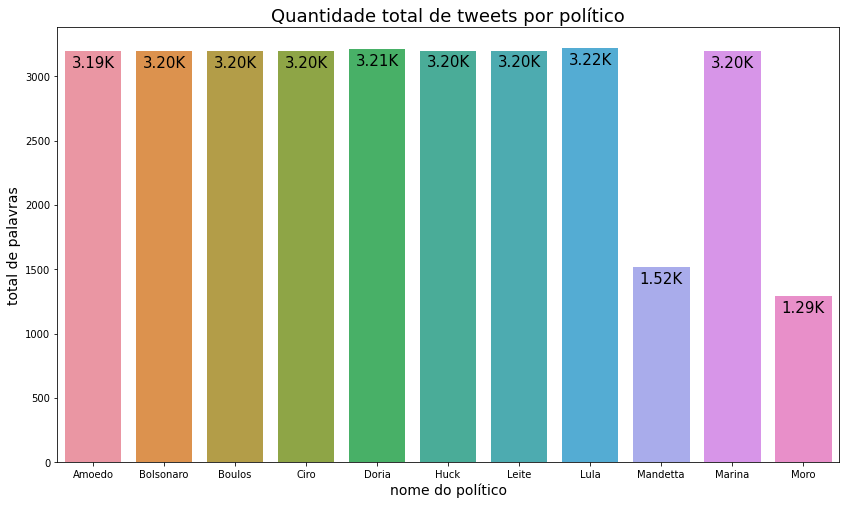

In [76]:
#quantidade de tweets por político

df_plot = df_politicos.groupby('nome').agg(total =('text','count'))
df_plot.reset_index(inplace=True)

plt.figure(figsize=(14, 8))
splot=sns.barplot(x="nome", y="total", data=df_plot)
plt.xlabel("nome do político", size=14)
plt.ylabel("total de palavras", size=14)
plt.title("Quantidade total de tweets por político", size=18)
for p in splot.patches:
    splot.annotate(format((p.get_height()/1000), '.2f')+"K", 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  size=15,
                  xytext = (0, -12), 
                  textcoords = 'offset points')

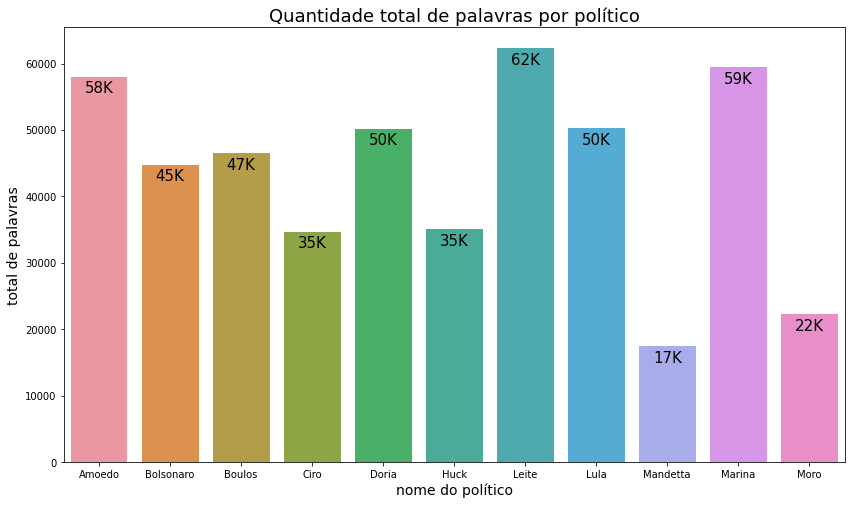

In [174]:
# quantidade de palavras por político

df_plot = df_palavras.groupby('nome').agg(total =('palavra','count'))
df_plot.reset_index(inplace=True)

plt.figure(figsize=(14, 8))
splot=sns.barplot(x="nome", y="total", data=df_plot)
plt.xlabel("nome do político", size=14)
plt.ylabel("total de palavras", size=14)
plt.title("Quantidade total de palavras por político", size=18)
for p in splot.patches:
    splot.annotate(format(round(p.get_height()/1000), '.0f')+"K", 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  size=15,
                  xytext = (0, -12), 
                  textcoords = 'offset points')

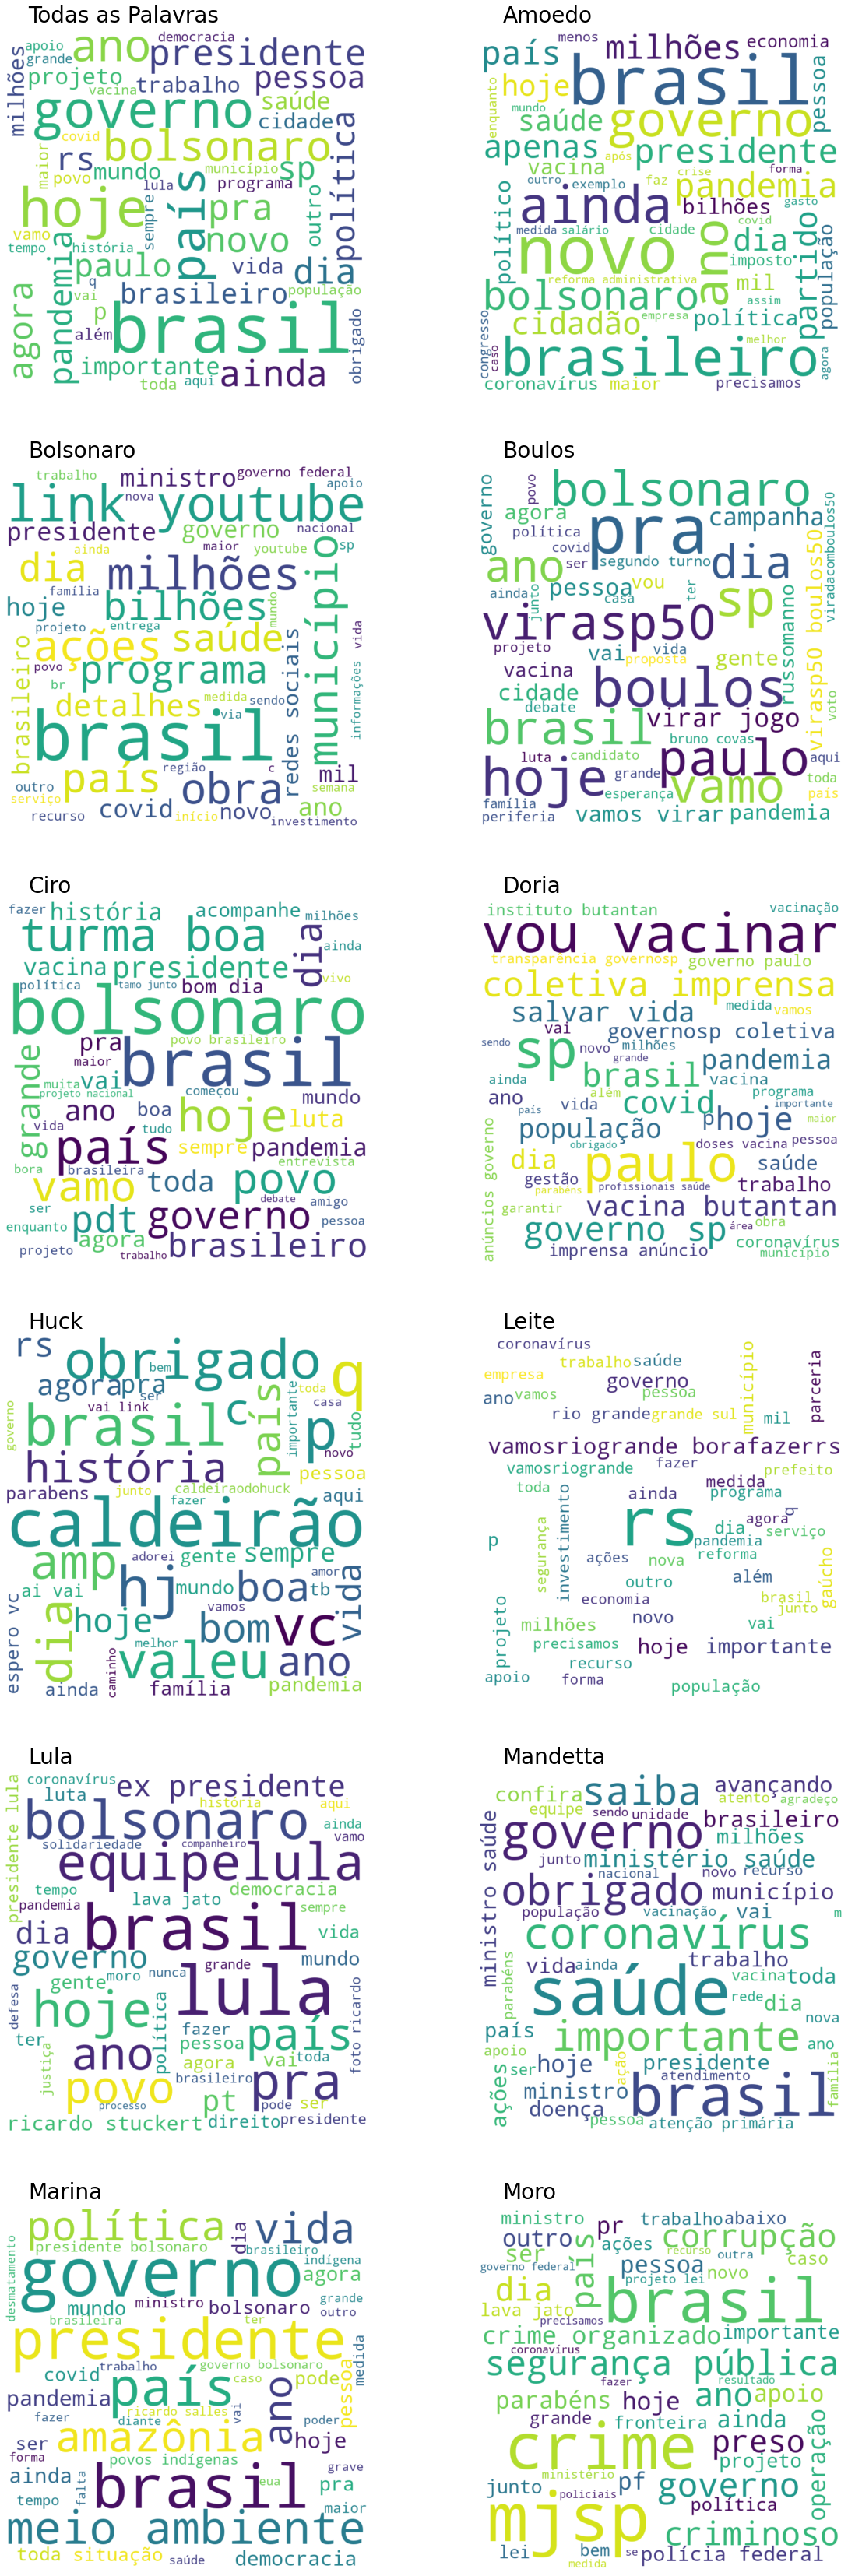

In [191]:
# wordcloud por político
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20, 60), facecolor='w')
xc = 0
yc = 1
sumario = " ".join(s for s in df_palavras['palavra'])
wordcloud = WordCloud(width=800, height=800, max_words=50, max_font_size=150, background_color='white').generate(sumario)
ax[0][0].imshow(wordcloud, interpolation="bilinear")
ax[0][0].text(50, -20, 'Todas os Políticos', fontsize=28, color='k')
ax[0][0].axis('off')

for idx in range(11):
    sumario = " ".join(s for s in df_palavras['palavra'][df_palavras['nome'] == nome_politicos[idx] ])
    wordcloud = WordCloud(width=800, height=800, max_words=50, max_font_size=150, background_color='white').generate(sumario)
    ax[xc][yc].imshow(wordcloud, interpolation="bilinear")
    ax[xc][yc].text(50, -20, nome_politicos[idx], fontsize=28, color='black')
    ax[xc][yc].axis('off')
    yc += 1
    if (yc == 2):
        yc = 0
        xc += 1
        if (xc == 6):
            xc = 0

#plt.tight_layout(pad=0) 
plt.show()

# Análise de frequências

In [232]:
# montando dataframe de frequências

c = Counter(df_palavras['palavra']).most_common()
df_palavras_freq = pd.DataFrame(c, columns=['palavra', 'frequencia'])
#for politico in nome_politicos:
c = Counter(df_palavras['palavra'][df_palavras['nome'] == 'Amoedo']).most_common()
d = pd.DataFrame(c, columns=['palavra', 'Amoedo'])
#d
df_palavras_freq.merge(d, on='palavra', how='left')
df_palavras_freq

palavra  frequencia
0          brasil        3492
1         governo        2907
2            hoje        2275
3           saúde        2040
4       bolsonaro        2032
...           ...         ...
40662     relatar           1
40663   inusitado           1
40664  executivas           1
40665       darei           1
40666         ola           1

[40667 rows x 2 columns]

In [43]:
df.sort_values('frequencia', ascending=True)[:20]

candidato              texto  frequencia
5343       Huck  visitandoopassado          11
1382     Marina          amazônica          11
4952       Lula              levar          11
6100       Huck        brasileiras          11
6097       Lula                tal          11
4957     Amoedo        necessidade          11
6096      Doria        respeitando          11
3200     Boulos              jeito          11
7229     Amoedo               acha          11
8120       Ciro            emprego          11
6066      Doria              muita          11
2355  Bolsonaro           recordes          11
3193     Amoedo              massa          11
6054  Bolsonaro            décadas          11
3188       Huck             cuidar          11
6053     Marina            escolha          11
4979       Lula          diferente          11
1361       Ciro              claro          11
6044  Bolsonaro          policiais          11
8097      Leite       empreendedor          11